# End to end examples

## Power generation

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/EX-powergen") ; Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\EX-powergen`


> Initial data processing <br>
> Adjusting the scientific types <br>
> Exploratory Data Analysis <br>
> Models <br>
> Model evaluation <br>

### Initial data processing

---

In this tutorial we are fitting solar and wind power generation output for Germany using weather data. We focus on the use of a simple linear estimator. Let's load the required packages to get started.

In [4]:
using MLJ
using UrlDownload
using PyPlot
import DataFrames: DataFrame, describe, names, select!
using Statistics

LinearRegressor = @load LinearRegressor pkg = MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJLinearModels ✔


MLJLinearModels.LinearRegressor

The power generation and weather data come from two separate datasets. We downloaded both datasets from Open Power networks. The power generation data is available here and the weather data is available here. Note that the first row in both datasets contains headers; hence we don't need to provide any.

In [5]:
data_repo = "https://raw.githubusercontent.com/tlienart/DataScienceTutorialsData.jl/master/data"

url_power   = data_repo * "/power_syst/DE_power_hourly.csv"
url_weather = data_repo * "/power_syst/DE_weather_data.csv"

power   = DataFrame(urldownload(url_power))
weather = DataFrame(urldownload(url_weather));

We've loaded both datasets but only have a rough idea of what's in each of them. Let's get a quick overview of the power dataset:

In [6]:
describe(power, :mean, :nmissing)

,variable,mean,nmissing
,Symbol,Union…,Int64
1,utc_timestamp,,0
2,cet_cest_timestamp,,0
3,DE_load_actual_entsoe_power_statistics,59050.7,0
4,DE_load_actual_entsoe_transparency,55062.6,0
5,DE_load_forecast_entsoe_transparency,54235.2,48
6,DE_price_day_ahead,29.1348,1
7,DE_solar_capacity,39560.4,0
8,DE_solar_generation_actual,3566.92,0
9,DE_solar_profile,0.0901202,0


and the weather dataset(we only show the first 20 rows as there's 150 features):

In [7]:
first(describe(weather, :mean, :nmissing), 20)

,variable,mean,nmissing
,Symbol,Union…,Int64
1,utc_timestamp,,0
2,DE11_windspeed_10m,3.64385,0
3,DE11_temperature,8.74556,0
4,DE11_radiation_direct_horizontal,83.1536,0
5,DE11_radiation_diffuse_horizontal,56.3569,0
6,DE12_windspeed_10m,3.58421,0
7,DE12_temperature,9.34965,0
8,DE12_radiation_direct_horizontal,80.6525,0
9,DE12_radiation_diffuse_horizontal,56.7742,0


Let's first consider the columns of the power DataFrame. For the purpose of this tutorial we are only interested in actual wind and solar generation. So we select a subset of the power dataframe containing only `:utc_timestamp`, `:DE_solar_generation_actual` and `:DE_wind_generation_actual`:

In [8]:
select!(power, [:utc_timestamp, :DE_solar_generation_actual, :DE_wind_generation_actual]);

Inspection of the column names in the weather DataFrame shows that we have weather data at the regional level (38 NUTS-2 statistical regions), which consists of four different weather variables: `_windspeed_10m`, `_temperature`, `_radiation_direct_horizontal`, `_radiation_diffuse_horizontal`. To match the structure of the power data, we need to aggregate at the country level. We do this by calculating the country-level average across all 38 regions, for each weather variable. This means we need to calculate an average across columns of the DataFrame that refer to the same weather variable. To do this we define a simple function to filter columns based on weather variable name and create new dataframes.

In [10]:
colnames = names(weather)

filter_by_name(name, cols) = filter(cn -> occursin(name, String(cn)), cols)

wind = weather[:, filter_by_name("windspeed", colnames)]
temp = weather[:, filter_by_name("temperature", colnames)]
raddir = weather[:, filter_by_name("radiation_direct", colnames)]
raddif = weather[:, filter_by_name("radiation_diffuse", colnames)];

Next, we create a new column in each DataFrame to store the country-level mean and calculate the mean. We use a nested loop. The lower level loop iterates over all rows of a given DataFrame, the higher-level loop iterates over all dataframes in the df Array.

In [11]:
dfs = [wind, temp, raddir, raddif]
col_mean = [:windspeed_mean, :temp_mean, :raddir_mean, :raddif_mean];

the zip function associates elements of two objects in the same position with one another:

In [13]:
n_rows = size(first(dfs), 1)
for (df, name) in zip(dfs, col_mean)
    df[!, name] = zeros(n_rows)
    for (i, row) in enumerate(eachrow(df))
        df[i, name] = mean(row)
    end
end;

Now that we have all variables we need to conduct our analysis, let's gather them in a single DataFrame...

In [14]:
data = DataFrame(
    Timestamp = weather.utc_timestamp,
    Solar_gen = power.DE_solar_generation_actual,
    Wind_gen = power.DE_wind_generation_actual,
    Windspeed = wind.windspeed_mean,
    Temperature = temp.temp_mean,
    Radiation_dir = raddir.raddir_mean,
    Radiation_dif = raddif.raddif_mean
);

...and have a look at their summary statistics

In [15]:
describe(data, :mean, :median, :nmissing)

,variable,mean,median,nmissing
,Symbol,Union…,Union…,Int64
1,Timestamp,,,0
2,Solar_gen,3566.92,53.0,0
3,Wind_gen,9684.06,7754.0,0
4,Windspeed,4.04812,3.65154,0
5,Temperature,8.57928,7.32667,0
6,Radiation_dir,74.0164,0.1769,0
7,Radiation_dif,54.1079,2.00599,0


Note that the `describe()` function provides you with information about missing values for each of the columns. Fortunately, there are none.

### Adjusting the scientific types

Let's check the default scientific type that's currently associated with the data features:

In [16]:
schema(data)

┌───────────────┬────────────┬──────────┐
│ names         │ scitypes   │ types    │
├───────────────┼────────────┼──────────┤
│ Timestamp     │ Textual    │ String31 │
│ Solar_gen     │ Count      │ Int64    │
│ Wind_gen      │ Count      │ Int64    │
│ Windspeed     │ Continuous │ Float64  │
│ Temperature   │ Continuous │ Float64  │
│ Radiation_dir │ Continuous │ Float64  │
│ Radiation_dif │ Continuous │ Float64  │
└───────────────┴────────────┴──────────┘


It is important that the scientific type of the variables corresponds to one of the types allowed for use with the models you are planning to use. (For more guidance on this, see the Scientific Type tutorial. The scientific type of both `Wind_gen` and `Solar_gen` is currently `Count`. Let's coerce them to `Continuous`.

In [17]:
coerce!(data, :Wind_gen => Continuous)
coerce!(data, :Solar_gen => Continuous)

schema(data)

┌───────────────┬────────────┬──────────┐
│ names         │ scitypes   │ types    │
├───────────────┼────────────┼──────────┤
│ Timestamp     │ Textual    │ String31 │
│ Solar_gen     │ Continuous │ Float64  │
│ Wind_gen      │ Continuous │ Float64  │
│ Windspeed     │ Continuous │ Float64  │
│ Temperature   │ Continuous │ Float64  │
│ Radiation_dir │ Continuous │ Float64  │
│ Radiation_dif │ Continuous │ Float64  │
└───────────────┴────────────┴──────────┘


We're now ready to go!

### Exploratory Data Analysis

---

To get a better understanding of our targets, let's plot their respective distributions.

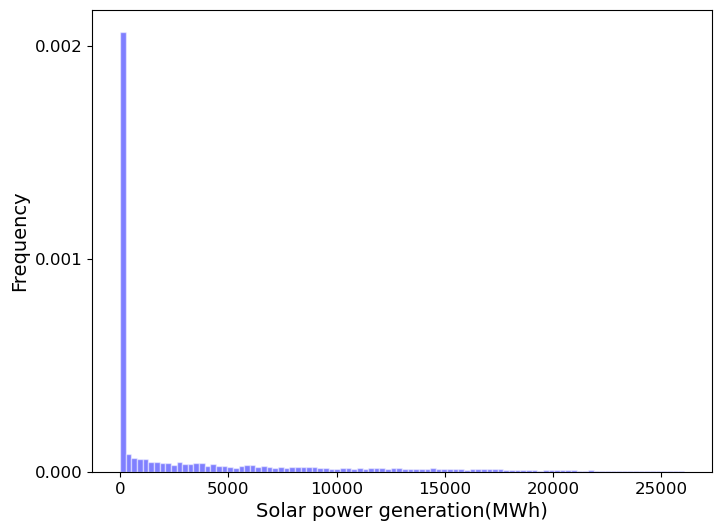

In [19]:
figure(figsize=(8, 6))
hist(data.Solar_gen, color = "blue", edgecolor = "white", bins = 100, 
    density = true, alpha = 0.5)
xlabel("Solar power generation(MWh)", fontsize = 14)
ylabel("Frequency", fontsize = 14)
xticks(fontsize = 12)
yticks([0, 1e-3, 2e-3], fontsize = 12)

savefig("./plots/4.10.1.png")

As one might expect, the sun doesn't always shine (and certainly not at night), hence there is a very high proportion of observations whose value is equal or close to 0. The distribution of wind power generation looks markedly different

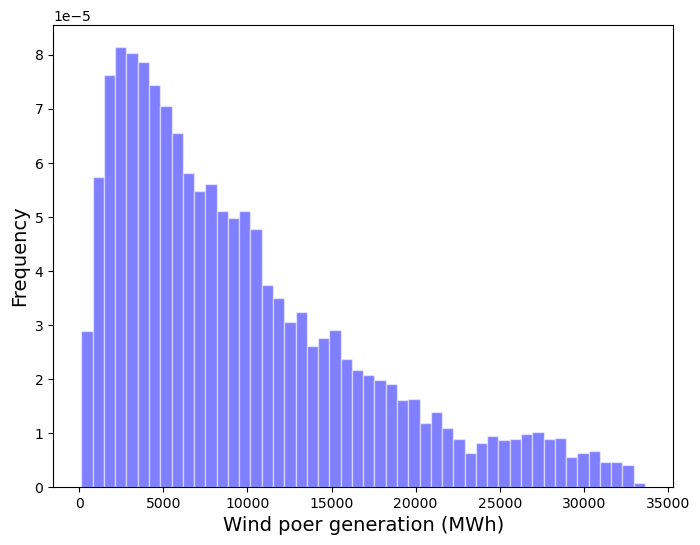

In [21]:
figure(figsize = (8,6))
hist(data.Wind_gen, color = "blue", edgecolor = "white", bins = 50,
    density = true, alpha = 0.5)
xlabel("Wind poer generation (MWh)", fontsize = 14)
ylabel("Frequency", fontsize = 14)

savefig("./plots/4.10.2.png")

Finally, before fitting the estimator, we might want to gauge what to expect from them by looking at scatter plots. Let's look at solar power first.

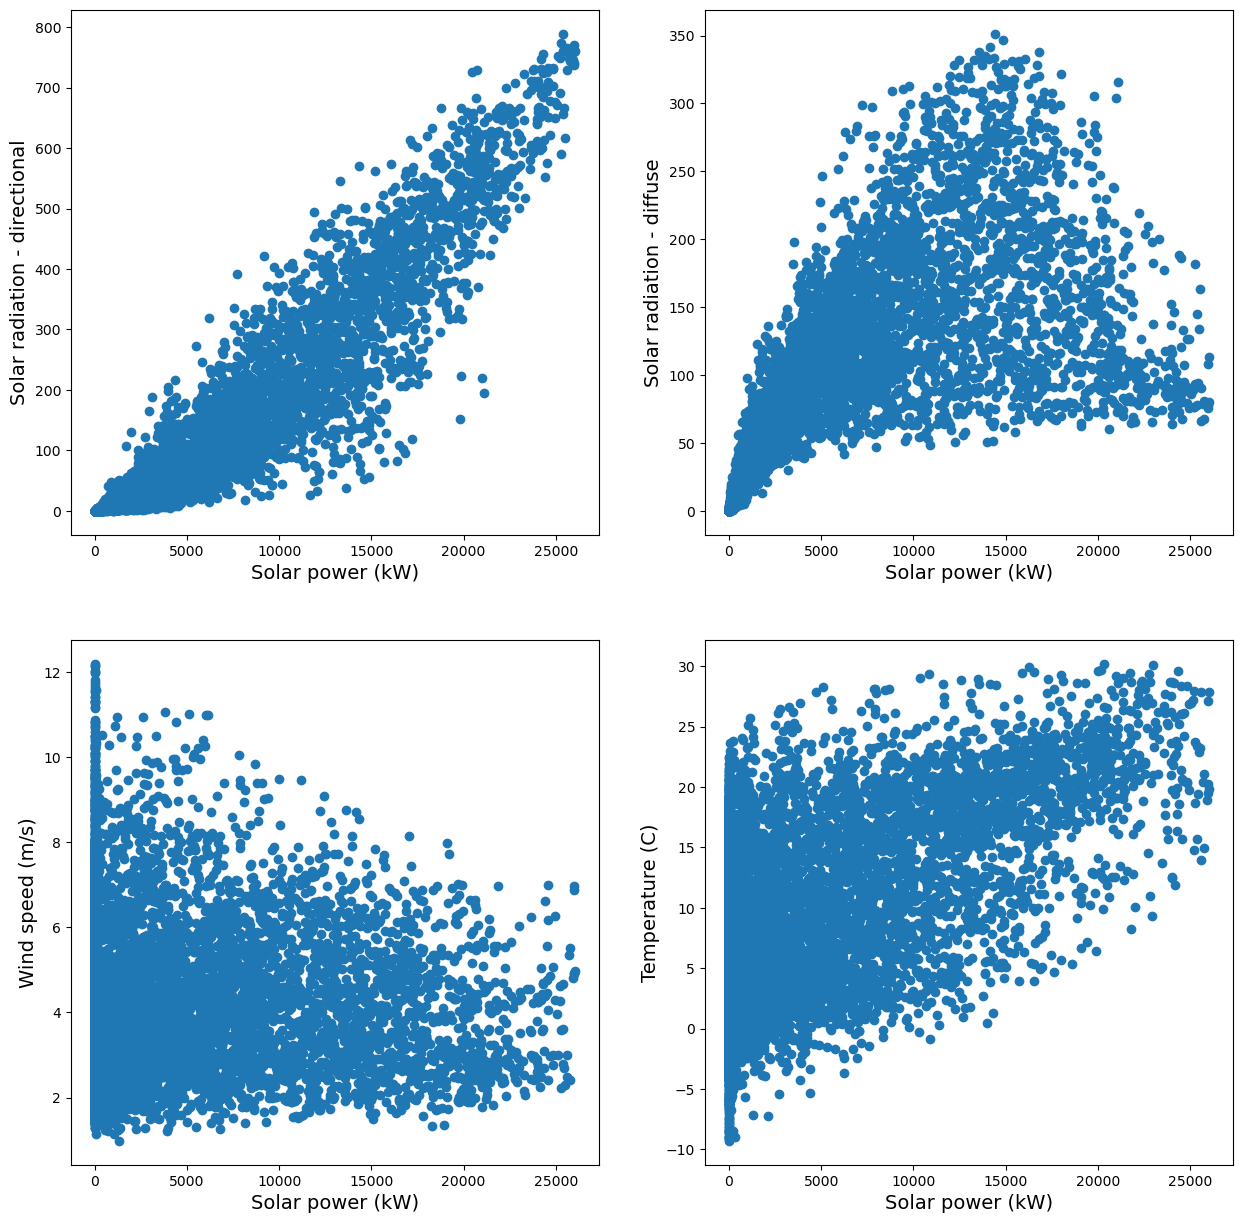

In [23]:
fig = figure(figsize = (15, 15))

subplot(221)
scatter(data.Solar_gen, data.Radiation_dir)
xlabel("Solar power (kW)", fontsize = 14)
ylabel("Solar radiation - directional", fontsize = 14)

subplot(222)
scatter(data.Solar_gen, data.Radiation_dif)
xlabel("Solar power (kW)", fontsize = 14)
ylabel("Solar radiation - diffuse", fontsize = 14)

subplot(223)
scatter(data.Solar_gen, data.Windspeed)
xlabel("Solar power (kW)", fontsize = 14)
ylabel("Wind speed (m/s)", fontsize = 14)

subplot(224)
scatter(data.Solar_gen, data.Temperature)
xlabel("Solar power (kW)", fontsize = 14)
ylabel("Temperature (C)", fontsize = 14)

savefig("./plots/4.10.3.png")

Then at wind generation

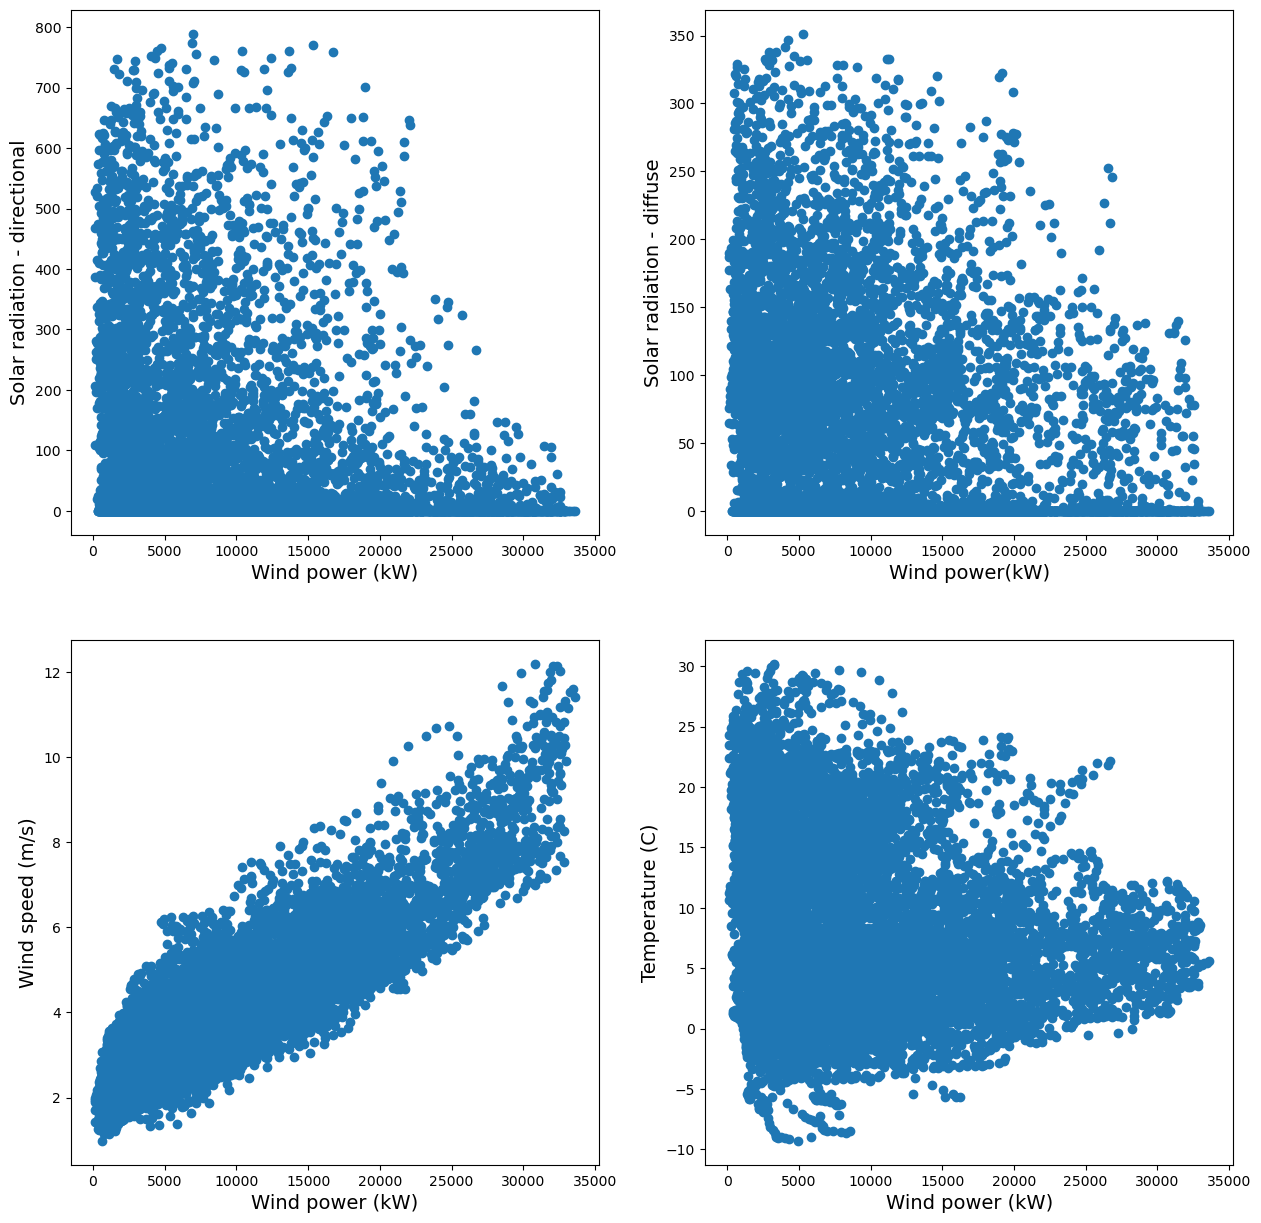

In [26]:
fig = figure(figsize = (15, 15))

subplot(221)
scatter(data.Wind_gen, data.Radiation_dir)
xlabel("Wind power (kW)", fontsize = 14)
ylabel("Solar radiation - directional", fontsize = 14)

subplot(222)
scatter(data.Wind_gen, data.Radiation_dif)
xlabel("Wind power(kW)", fontsize = 14)
ylabel("Solar radiation - diffuse", fontsize = 14)

subplot(223)
scatter(data.Wind_gen, data.Windspeed)
xlabel("Wind power (kW)", fontsize = 14)
ylabel("Wind speed (m/s)", fontsize = 14)

subplot(224)
scatter(data.Wind_gen, data.Temperature)
xlabel("Wind power (kW)", fontsize = 14)
ylabel("Temperature (C)", fontsize = 14)

savefig("./plots/4.10.4.png")

As expected, solar power generation shows a strong relationship to solar irradiance while wind power generation denotes a strong relationship to wind speed.

### Models

----

Let's fit a linear regression to our data. We focus on fitting the wind power generation but the same procedure could be applied for the solar power generation (a good exercise!).

In [27]:
y_wind = data.Wind_gen
X = data[:, [:Windspeed, :Temperature, :Radiation_dir, :Radiation_dif]];

Next, we partition the data in training and test set; we choose the usual 70-30 split:

In [28]:
train, test = partition(collect(eachindex(y_wind)), 0.7, shuffle = true, rng = 5);

then we instantiate a model and fit it:

In [30]:
linReg = LinearRegressor()
m_linReg = machine(linReg, X, y_wind)
fit!(m_linReg, rows = train)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{LinearRegressor,…} trained 1 time; caches data
  model: MLJLinearModels.LinearRegressor
  args: 
    1:	Source @415 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @034 ⏎ `AbstractVector{Continuous}`


### Model evaluation

We've now fitted the model for wind power generation (`Wind_gen`). Let's use it to predict values over the test set and investigate the performance:

In [31]:
y_hat = MLJ.predict(m_linReg, rows = test);

We can start by visualising the observed and predicted valzes of wind power generation.

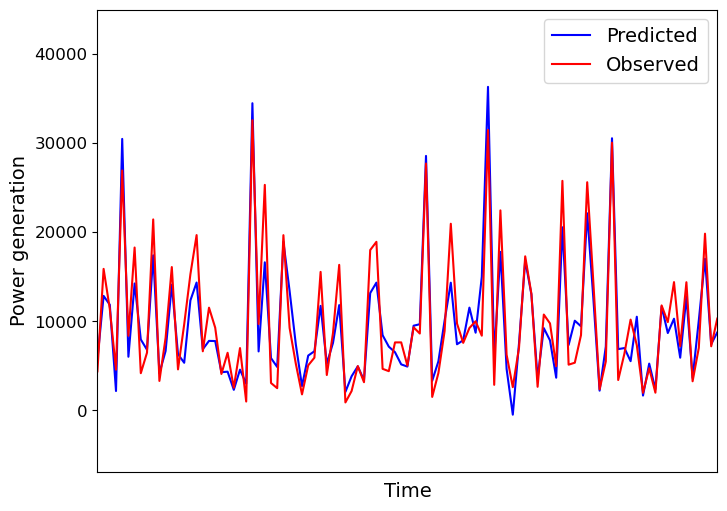

In [33]:
figure(figsize = (8, 6))
plot(y_hat, color = "blue", label = "Predicted")
plot(y_wind[test], color = "red", label = "Observed")
xlabel("Time", fontsize = 14)
ylabel("Power generation", fontsize = 14)
xticks([])
yticks(fontsize = 12)
xlim(0, 100)
legend(fontsize = 14)

savefig("./plots/4.10.5.png")

Let's look at the RMSE on the training and test sets.

In [34]:
rms(y_wind[train], MLJ.predict(m_linReg, rows = train))

2934.599963885751

on the test set...

In [35]:
rms(y_wind[test], y_hat)

2872.517439095297

Finally, let's plot the residuals to see if there is any obvious remaining structure in them.

In [36]:
res = y_hat .- y_wind[test];

Let's look at the stem plot of the residuals to check if there's any structure we might not have picked up:

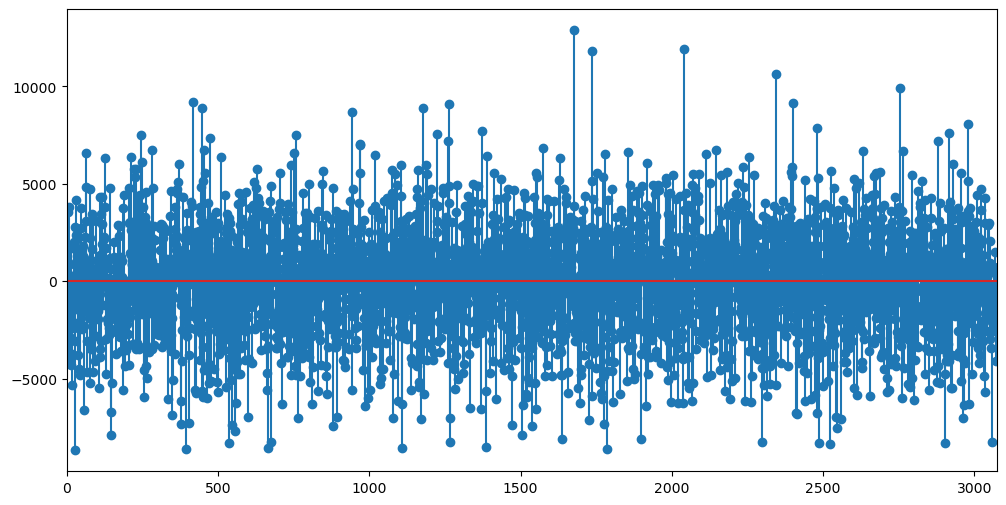

In [39]:
figure(figsize = (12, 6))
stem(res)
xlim(0, length(res))
savefig("./plots/4.10.6.png")

Nothing really stands out, the distribution also looks ok:

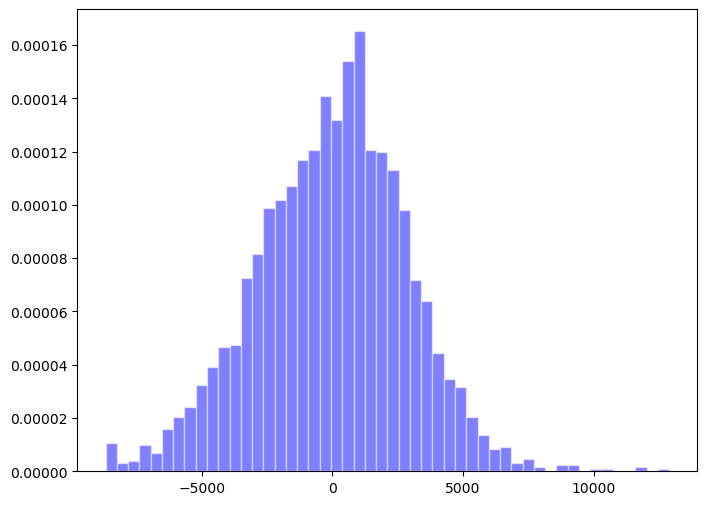

In [41]:
figure(figsize=(8, 6))
hist(res, color = "blue", edgecolor = "white", bins = 50, density = true, alpha = 0.5)
savefig("./plots/4.10.7.png")

We leave it at that for now, I hope you found this tutorial interesting.